## Part 2: Enhancing the chatbot with tools
Let's integrate a web search tool.

In [22]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from configuracion import TAVILY_API_KEY

tavilySearchAPIWrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(
    api_wrapper=tavilySearchAPIWrapper,
    max_results=2)
tool.invoke("ventilador inyección en línea conducto circular 390 CFM presión 1.30 in potencia 273.6W 115V dimensiones 397x381x397 mm")


[{'url': 'https://sbvindustriales.com/product/csp-a390/',
  'content': 'CSP-A390 – sbvindustriales Home\xa0/\xa0Extractores y Ventiladores\xa0/\xa0CSP-A390 CSP-A390 VENTILADOR EN LINEA MARCA GREENHECK, MODELO CSP-A390 PARA 412 CFM@0 IN.WG, MOTOR ODP DE 115V/1F/60HZ. •Motor rated for continuous use •Motor with 40 Degree C Ambient Temperature CSP-A390 quantity  Add to cart SKU: CSP-A390 Category: Extractores y Ventiladores Tags: exhaust, extractor, greenheck, HVAC VENTILADOR EN LINEA MARCA GREENHECK, MODELO CSP-A390 PARA 412 CFM@0 IN.WG, MOTOR ODP DE 115V/1F/60HZ. •Motor rated for continuous use •Motor with 40 Degree C Ambient Temperature Email\xa0* Save my name, email, and website in this browser for the next time I comment. SP-B200 ------- $195.98 Add to cart CUBE-160-10 ----------- $1,545.18 Add to cart SP-B110 ------- $138.34 Add to cart CUBE-100-3 ---------- $1,207.77 Add to cart'},
 {'url': 'https://www.systemair.com/es-mx/productos/ventiladores/ventiladores-de-conducto/ventiladore

In [16]:
from typing import Annotated
from langchain_google_vertexai import ChatVertexAI
from typing_extensions import TypedDict
from configuracion import MODEL_GEMINI, GCP_PROJECT_ID, GCP_REGION, scoped_creds

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

model = ChatVertexAI(
                model_name=MODEL_GEMINI,
                project=GCP_PROJECT_ID,
                location=GCP_REGION,
                credentials=scoped_creds,
                max_output_tokens=8192,
                temperature=0.2,
        )
llm_with_tools = model.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)


Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools toa  new node

Below, we implement a *BasicToolNode* taht checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Antropic, OpenAI, Gemini and a number of ther LLM providers.

We will later replace this with LangGraph's prebuilt **[ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)** to speed things up, but building it ourselves first is instructive.

In [8]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage"""
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__ (self, inputs:dict):
        if messages := inputs.get("messages", []):#En python una lista vacía se evalua como False
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name= tool_call["name"],
                    tool_call_id= tool_call["id"]
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [9]:
from typing import Literal
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last
    message has a tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"no messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

#The tools_condition function return "tools" if the chatbot asks to use a tool, and "END" if
#it's fine directly responding. This conditional routing  defines the main agent loop

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END}
)

#aAny time a tools is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

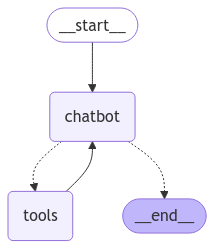

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages":[("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [13]:
#Now we can ask the bot questions outside its training data.
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Lo siento, no tengo información sobre "LangGraph". No puedo proporcionar una definición o descripción de este término. 

Assistant: 
Assistant: [{"url": "https://blockchain.news/news/langchain-new-features-upcoming-events-update", "content": "LangChain, a leading platform in the AI development space, has released its latest updates, showcasing new use cases and enhancements across its ecosystem. According to the LangChain Blog, the updates cover advancements in LangGraph Cloud, LangSmith's self-improving evaluators, and revamped documentation for LangGraph."}, {"url": "https://blockchain.news/news/langchain-unveils-langgraph-platform", "content": "News Bitcoin News Ethereum News Web3 News AI AI News ChatGPT News AI Image NSFW AI NSFW AI Image Generator All NSFW AI AI Text AI Search AI Agent LangChain Unveils LangGraph Platform with Enhanced Deployment Options - Blockchain.News LangChain Unveils LangGraph Platform with Enhanced Deployment Options LangChain introduces LangGrap